# Transformers From Scratch

The video from the workshop (in Swedish) can be found on [YouTube](https://youtu.be/bHIU96D8SSQ).

Today I'm taking **huge inspiration from Peter Bloem** 
(Vrije Universiteit Amsterdam) which is a [great blog post](http://peterbloem.nl/blog/transformers) & [video lecture](https://youtu.be/KmAISyVvE1Y?list=PLIXJ-Sacf8u60G1TwcznBmK6rEL3gmZmV). It's **essentially a 80-90 % copy of the blog, with minor modifications and reworked code into TODOs** to make it more like a workshop using the Jupyter format (fitting nicely with Google Colab).  
_As demonstrations in the end I integrate PyTorch-code with fast.ai framework._  
These demos are done to have a foundation for you to play around with as the models are not deep enough and does not train enough to really show-case the power of Transformers.

I want to note that the original blog by Peter Bloems is a work of art and does a better job at visualizing graphics in combination with text.

Finally this blog was done to support a 'Competence Night' in Machine Learning that I did @ AFRY.

## Transformers explained
> Transformers are a very exciting family of machine learning architectures. Many good tutorials exist but in the last few years, transformers have mostly become simpler, so that it is now much more straightforward to explain how modern architectures work. This post (read: Peter Bloems blog) is an attempt to explain directly how modern transformers work, and why, without some of the historical baggage.

It's assumed a basic understanding of neural networks and backpropagation, for those that are not sure you can either brush up your knowledge in [this video](https://youtu.be/1NVgspM98W0) and learn how they're used today [here](https://youtu.be/DidHjsp_OV0).

Further we'll use PyTorch, with some fast.ai for the demos in appendix, to implement the full self attention & transformer module(s).

## Self-attention
The fundamental operation of any transformer architecture is the self-attention operation.

**Self-attention is a sequence-to-sequence operation**, that is we input a sequence and we have a sequence returned.  
Let's say we've got `x1..xn` as input and `y1..yn` as output where each vector is dimensioned `k`.

To produce output vector 𝐲i, the self attention operation simply takes a weighted average over all the input vectors

$y_i = \sum_{j=0}^{j=k}{w_{ij}x_j}$

Where the weights summed over $j=0..k$ is equal to $1$. $w_{ij}$ is not a parameter but is derived from a function over $x_i$ and $x_j$.  
The simplest being the dot-product.

$w_{ij}^{'} = x_i^Tx_j$

Where $x_i$ is at the same position as $y_i$ and $x_j$ traverses through all k values. For $x_{i+1}$ we get a completely different output!

Because the dot product has no bounds we apply softmax to the result, so that the whole sequence sum to $1$.

$w_{ij} = \frac{\text{exp } w_{ij}^{'}}{\sum_{j} \text{exp } w_{ij}^{'}}$

And that's really it.

![attention](https://user-images.githubusercontent.com/7490199/218255581-54624bd8-de0f-4340-a085-d6605b3d5310.png)

> A visual illustration of basic self-attention. Note that the softmax operation over the weights is not illustrated.

Obviously we need to apply a few more things to create a Transformer, but we'll get to that.

## Understanding how it works

As shown previously we'll use Movie Recommender system to show _why_ the dot-product works.  
Say you created your manually annotated data

![image](https://user-images.githubusercontent.com/7490199/218255785-253e9052-3cbc-4fb7-b797-5fbd102432e9.png)

As you see, negative + negative = positive, positive + positive = positive.  
The magnitude of the score increases the final outcome.

So combining these two vectors together will work out real nice!

This might not be so practical in reality and as such we make the movie and user features _parameters_ of the model. Then we ask the user for for a small number of movies they like and optimize the features so that their dot product matches the known likes.  
Even when not manually giving any features meaningful data is extracted.

Even though we don’t tell the model what any of the features should mean, in practice, it turns out that after training the features do actually reflect meaningful semantics about the movie content.

![image](https://user-images.githubusercontent.com/7490199/218255808-6dd74148-9dd1-40dd-b158-2b7935ae49a5.png)

This is in essence the same as self-attention.

Using word embeddings on a sentence as  

$v_{the}, v_{cat}, v_{walk}$

and feed it into self attention we get the output-vectors y,

$y_{the}, y_{cat}, y_{walk}$

where y-vectors are the _weighted sum over all embedding vectors in the first sequence_, weighted by their (normalized) dot-product with $v_{cat}$.  
E.g. $y_{the}$ = $v_{the} * v_{the} + v_{the} * v_{cat} + v_{the} * v_{walk}$.

Because _v_ is learned this will continually be updated to work better. While updating how _v_ is created most likely _walk_ and _cat_ will have a high dot-product as those are correlated.

This is the basic intuition. _Please note:_

- No parameters (yet) so the upstream mechanism creating the embeddings fully drives the self-attention by learning representations with particular dot-products
- Self-attention see the input as a _bag_, i.e. not a continuous input as it is, e.g. it is _permutation equivariant_. 

## In Pytorch: basic self-attention

> What I cannot create, I do not understand _- Feynman_

The first thing we need to implement is matrix multiplications, which will be done through _torch_ as native python loops are too slow.

Input: $t$ vectors, dimension $k$ and $b$ mini-batches (tensor: $b, t, k$)  


We’ll represent the input, a sequence of t vectors of dimension k as a t by k matrix 𝐗. Including a minibatch dimension b, gives us an input tensor of size (b,t,k).

The set of all raw dot products w′ij forms a matrix, which we can compute simply by multiplying 𝐗 by its transpose:

Let's code!

In [ ]:
class TODO(Exception):
    """Raised when there is something TODO"""
    pass

In [ ]:
import torch
import torch.nn.functional as F

# assume we have some tensor x with size (b=1, t=3, k=3)
x = torch.array([[1.,2.,3.,
                 1.,2.,3.,
                 1.,2.,3.]])

In [ ]:
# batch matrix multiplication
raw_weights = raise TODO("Use torch batch-matrix-multiply (bmm) to do x*x^T. Remember there's 3 dimensions!")

# Apply row-wise Softmax
weights = raise TODO("Use functional softmax to apply softmax row-wise (along which dim?)")

# creating y
y = torch.bmm(weights, x)

And that's it. We have created basic self-attention which is the basis of Transformers (state-of-the-art).

## Additional Tricks

To implement Transformers fully we need to add a few tricks.

### 1) Queries, keys & values

Each input-vector $x_i$ is used 3 times

1. Creating its own weight for $y_i$
2. Creating others weight for $y$ ($y_j$)
3. Used as a part of the weighted sum for each output $y$

This is often called the **query**, the **key**, and the **value** (explained later).  
We update the network to instead use _three weight-matrices_, one for each task, making it more controllable. Adding $W_k, W_q, W_v$ of size $k*k$, we've got

$q_i = W_qx_i, k_i = W_kx_i, v_i = W_vx_i$  
$w_{ij}^{'} = q_i^Tk_j$
$w_ {ij} = softmax(w_{ij}^{'})$  
$y_i = \sum_j w_{ij}v_j$

We've now given the Self Attention some controllable parameters & allows modification to the input vector to fit the task at hands.

![image](https://user-images.githubusercontent.com/7490199/218255869-749bfc2e-df1f-498d-8261-47b2d3230e35.png)

> Illustration of the self-attention with key (red), query (query) and value (green) transformations. Remember old image and compare!

### 2) Scaling the Dot Product

Softmax can be _very sensitive to large values_, exploding gradient or making it slow to learn.  
I don't recall where but ~ 8 years ago someone figured out that scaling the value by $\frac{1}{\sqrt{k}}$ where $k$ is the embedding dimension.

$w_{ij}^{'} = \frac{q_i^Tk_j}{\sqrt{k}}$

_Why $\sqrt{k}$? Imagine a vector in $ℝk$ with values all $c$. Its Euclidean length is $\sqrt{k}c$. Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors._

### 3) Multi-head Attention
The final improvement is to allow word to have different meanings with different neighbours (basically what _ngram_ achieves).

By adding multiple, indexed _r_, self attention mechanisms with different matrices, $W_q^r$ etc. These are called _attention heads_.

For input $x_i$ each attention head produces a different output vector $y_i^r$. We concatenate these, and pass them through a linear transformation to reduce the dimension back to $k$. **Remember what is a linear transformation?**

**Narrow and wide self-attention**. 
There's two ways to apply _Multi-Head Self-Attention_.  
1. (_narrow_) Cut embedding vector into chunks
    - 8 heads & $k=256$ --> 8 chunks of size 32
    - Each chunk gets Q, K, V matrices ($W_q^r$,...) ($32\times32$)
2.  (_wide_) Make matrices $256\times256$ and apply each head to the whole 256-vector
    - First (_narrow_) = faster & less memory
    - Second (_wider_) = better result

Only second (_wider_) variant described.

## In Pytorch: complete self-attention

Let's make the implementation with bells & whistles.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class SelfAttention():
  def __init__(self, k, heads=8):
    raise TODO("Make SelfAttention a torch module (nn.Module)")
    super().__init__()
    self.k, self.heads = k, heads

![image](https://user-images.githubusercontent.com/7490199/218257812-fe88920f-e431-441a-8bda-047279aa3c60.png)

> Combining three attention heads into one matrix multiplication (for the queries).

_h_ attention-heads considered as _h_ separate sets of $W_q^r,W_k^r,W_v^r$, but as shown in image above **a more efficient approach is possible**.

Combine all heads into three single $k\times hk$ matrices.  
This means that we can compute the concatenated _queries_, _keys_ & _values_ in a single matrix multiplication.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k, self.heads = k, heads

    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = raise TODO("Create a linear layer of k * hk size, no bias")
    self.toqueries = raise TODO("Create a linear layer of k * hk size, no bias")
  	self.tovalues  = raise TODO("Create a linear layer of k * hk size, no bias")

	  # This unifies the outputs of the different heads into a single k-vector
	  self.unifyheads = raise TODO("Create a linear layer of k * hk size, WITH bias")

From here we can implement the computation of the self-attention (`forward` function). Where we first calculate _queries, keys & values_.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k, self.heads = k, heads

    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
  	self.tovalues  = nn.Linear(k, k * heads, bias=False)

	  # This unifies the outputs of the different heads into 
	  # a single k-vector
	  self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    queries = raise TODO("Create queries and then reshape into h separate matrices, using `view`")
    keys    = raise TODO("Create keys and then reshape into h separate matrices, using `view`")
    values  = raise TODO("Create values and then reshape into h separate matrices, using `view`")

Having reshaped _queries_ etc from $(b,t, h*k)$ into $(b,t,h,k)$ each head has its own dimension.

The step now is to _compute dot-product for each head_.  
We can batch this if we reshape the matrices into something that's possible to batch (transposing; as head/batch is not next to each-other). **costly**

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k, self.heads = k, heads

    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
  	self.tovalues  = nn.Linear(k, k * heads, bias=False)

	  # This unifies the outputs of the different heads into 
	  # a single k-vector
	  self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    queries = self.toqueries(x).view(b, t, h, k)
    keys    = self.tokeys(x)   .view(b, t, h, k)
    values  = self.tovalues(x) .view(b, t, h, k)

    # - fold heads into the batch dimension ... contiguous = reshapes matrix in memory
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    queries = raise TODO("Scale queries by k^(1/4)")
    keys    = raise TODO("Scale keys by k^(1/4)")

    # - get dot product of queries and keys, and scale
    dot = torch.bmm(queries, keys.transpose(1, 2))
    # - dot has size (b*h, t, k) containing raw weights

    dot = raise TODO("Normalize row-wise using F.softmax")
    # - dot now contains row-wise normalized weights

    # apply the self attention to the values
    out = torch.bmm(dot, values).view(b, h, t, k)

    # swap h, t back, unify heads
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)
    return raise TODO("Unify the heads into the classes again using unifyheads")

And there you have it: multi-head, scaled dot-product self attention.

## Building Transformers
A transformer is not just a self-attention layer, it is an architecture.

> Any architecture designed to process a connected set of units—such as the tokens in a sequence or the pixels in an image—where the only interaction between units is through self-attention.

Like most mechanism, e.g. convolutions, a standard approach as emerged. The first step is to wrap the self-attention into a block that we can repeat.

### The transformer block
There are some variations on how to build a basic transformer block, but most of them are structured roughly like this:

![image](https://user-images.githubusercontent.com/7490199/218257941-ac36177e-e00e-4544-9b69-0fc8f11b7b62.png)

- MultiLayer Perceptron = MLP = Basic Feed-forward Neural Network
- Blue lines = Residual Connection (allow the gradient to flow through the network on a kind of "highway", making the training faster and reducing "blown up gradients")

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, k, heads):
    super().__init__()

    self.attention = raise TODO("make a SelfAttention")

    self.norm1 = raise TODO("make a nn.LayerNorm of size k")
    self.norm2 = raise TODO("make a nn.LayerNorm of size k")

    # k * 4 is arbitrary, but needs to be larger than input/output layer (k)
    self.ff = raise TODO("create a MLP: Sequential(Linear(k, 4*k), ReLU, Linear(4*k, k))")

  def forward(self, x):
    attended = raise TODO("call your created attention on x")
    x = raise TODO("Use the first normalizer to normalizer attented+x")
    
    fedforward = raise TODO("Call feedforward (ff) on new x")
    return raise TODO("Finally normalize with 2nd on the addition of feedforward & x")

And that is really it! We have now built a Transformer Block & Self Attention. 

Now we want to use it :)

## Classification transformer

The simplest classification task is a _Sequence Classifier_.  
The IMDB Review dataset is a great contender to try things out with, where each review is `positive` or `negative`.

Essentially we'll create a chain of Transformers Block and input our embedded vectors of words, and in the end transforming the output into a single value (true/false).

### Output: producing a classifier

Most common way: _Global Average Pooling_ on final output sequence and map result to a _softmaxed class vector_.


![image](https://user-images.githubusercontent.com/7490199/218257961-1d764937-0dbe-4a25-8568-dc1d8a39dd31.png)

>Overview of a simple sequence classification transformer. The output sequence is averaged to produce a single vector representing the whole sequence. This vector is projected down to a vector with one element per class and softmaxed to produce probabilities.

### Input: Using Positions (think: ngram)
We've already discussed that the current model uses embedding layer but has no sense of sequence time slotting (~ ngram).  
We want our State-of-the-Art model to have a sense of order so we need to fix it.

Add a second vector of the same length as word embedding, that represent the position of the sentence+word, and add it to the word embedding. There's two ways to do this.

1. **Position Embedding** We simply embed the positions like we did the words.
    - Easy to implement
    - Works pretty good
    - Drawback is that we have to see sequences of every length during training, otherwise the position is not trained!
2. **Position Encoding** Position encodings work in the same way as embeddings, except that we don't learn the position vectors, we just choose some function $f:ℕ→ℝk$ to map the positions to real valued vectors, and let the network figure out how to interpret these encodings. 
    - E.g. sin/cos
    - Works with longer sequences than seen (might not work well, but it works!)
    - Drawback: choice of encoding function is a complicated hyperparameter, and more complicated implementation.

For this tutorial the **Position Embedding** is used.

### PyTorch

Let's implement this!

In [ ]:
class Transformer(nn.Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
        super().__init__()

        self.num_tokens = num_tokens
        self.token_emb = raise TODO("Create a Embedding layer (nn.X) with num_tokens & k")
        self.pos_emb = raise TODO("Create Embedding Layer with seq_length & k")

        # The sequence of transformer blocks that does all the 
        # heavy lifting
        blocks = []
        for i in range(depth):
            raise TODO("Append a TransformerBlock we recently created for each loop; and why not use list-comprehension?")
        self.t_blocks = raise TODO("Now make them a Sequential layer (*list = spread)")

		    # Maps the final output sequence to class logits
        self.to_probs = raise TODO("To get class logits we simply use a Linear layer of k * num_classes")

    def forward(self, x):
        """
        :param x: A (b, t) tensor of integer values representing 
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the 
                 classes (where c is the nr. of classes).
        """
		    # generate token embeddings
        tokens = raise TODO("Embedd the tokens")
        b, t, k = tokens.size()

		    # generate position embeddings
		    positions = torch.arange(t)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)
        
        x = tokens + positions
        x = raise TODO("Run the network through the tranformer blocks")
        
        # Average-pool over the t dimension and project to class 
        # probabilities
        x = raise TODO("Use the probability function, but first take the mean over dim=1 to average")
        return raise TODO("Use the F.log_softmax on dim=1 to normalize output!")

At depth 6, with a maximum sequence length of 512, this transformer achieves an accuracy of about 85%, competitive with results from RNN models, and much faster to train. To see the real near-human performance of transformers, we’d need to train a much deeper model on much more data. More about how to do that later.

## Text generation transformer
Let's move on!

In Text Generation we are not allowed to know the future during training, how else are we going to predict it? This means that we need to use an **autoregressive model**. 

For Text Generation we'll train a character-to-character prediction, the input is a sequence of characters and output is the input shifted one charafter to the left.

![image](https://user-images.githubusercontent.com/7490199/218257974-9275a97a-62c2-4439-a25d-136d77a24b4c.png)

For the usual RNN this is all that is needed, but as mentioned now we need to make our model _autoregressive_, meaning that it can't look ahead.  
This is done by applying a mask which disables all elements that are ahead of current index, as in image below.

![image](https://user-images.githubusercontent.com/7490199/218257983-fe48a555-4e81-4745-ab16-529980518eaf.png)

> Masking the self attention, to ensure that elements can only attend to input elements that precede them in the sequence. Note that the multiplication symbol is slightly misleading: we actually set the masked out elements (the white squares) to −∞

## In PyTorch
Implementing this in PyTorch

In [ ]:
class SelfAttentionAutoRegressive(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k, self.heads = k, heads

    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
  	self.tovalues  = nn.Linear(k, k * heads, bias=False)

	  # This unifies the outputs of the different heads into 
	  # a single k-vector
	  self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    queries = self.toqueries(x).view(b, t, h, k)
    keys    = self.tokeys(x)   .view(b, t, h, k)
    values  = self.tovalues(x) .view(b, t, h, k)

    # - fold heads into the batch dimension ... contiguous = reshapes matrix in memory
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    queries = queries / (k ** (1/4))
    keys    = keys / (k ** (1/4))

    # - get dot product of queries and keys, and scale
    dot = torch.bmm(queries, keys.transpose(1, 2))

    # === START OF CHANGES ===
    indices = torch.triu_indices(t, t, offset=1)
    dot[:, indices[0], indices[1]] = raise TODO("-inf; and think off what we are doing. triu_indices is shown below")
    # === END OF CHANGES ===

    # - dot has size (b*h, t, t) containing raw weights

    dot = F.softmax(dot, dim=2) 
    # - dot now contains row-wise normalized weights

    # apply the self attention to the values
    out = torch.bmm(dot, values).view(b, h, t, k)

    # swap h, t back, unify heads
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)
    return self.unifyheads(out)

In [ ]:
??torch.triu_indices

Once the model has been 'handicapped' as this we're ready to go!



If you'd like to learn the historical aspect of Transformers, some design consideration & more details please visit the [original blog](http://peterbloem.nl/blog/transformers) by Peter Bloem and finish that one!

I hope you found this helpful!  
**Please take a good look in Appendix for demos with Text Classification & Text Generation.**  
Do note that the depth should probably be increased as should the amount of data. Transformers improve a lot with time, depth & data (especially data!). 

Thanks  
~Hampus

# Appendix: Demos (Text Classification & Text Generation)
This appendix includes one demo of each type where I've integrated the PyTorch with fast.ai to smoothen the process from model to actually using it.


**DISCLAIMER:**  
- We should train on more data for a longer while to really showcase their prowess
- Use the full IMDB data to at least get a little better performance
- The demos are more wrapped code for you to play around with

With that in mind, please play around with this. Tweak parameters, add your own data and have fun!

## Dependencies
Simply run this block to 
- Upgrade fastai (2.0+)
- Import fastai

In [ ]:
%%capture
!pip install -U fastai

from fastai.text.all import *
from functools import partial # Can use partial to preload a transformer block

## Text Classification

The Text Classification is done on the IMDB challenge. There's code included for both IMDB_SAMPLE and IMDB where the sample is a little too small to actually get good stats on.

I think adding some more depth (perhaps 6 blocks?) will increase the accuracy even further.

### Model (Classifier)
Code we already wrote for the classifier

In [ ]:
class SelfAttention(Module):
  def __init__(self, k, heads=8):
    self.k, self.heads = k, heads

    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues  = nn.Linear(k, k * heads, bias=False)

    # This unifies the outputs of the different heads into 
    # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()
    h = self.heads
    
    assert self.k == k, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

    queries = self.toqueries(x).view(b, t, h, k)
    keys    = self.tokeys(x)   .view(b, t, h, k)
    values  = self.tovalues(x) .view(b, t, h, k)

    # - fold heads into the batch dimension ... contiguous = reshapes matrix in memory
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    queries = queries / (k ** (1/4))
    keys    = keys / (k ** (1/4))

    # - get dot product of queries and keys, and scale
    dot = torch.bmm(queries, keys.transpose(1, 2))

    assert dot.size() == (b*h, t, t)

    # - dot has size (b*h, t, t) containing raw weights
    dot = F.softmax(dot, dim=2) 
    # - dot now contains row-wise normalized weights

    # apply the self attention to the values
    out = torch.bmm(dot, values).view(b, h, t, k)

    # swap h, t back, unify heads
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)
    
    return self.unifyheads(out)

In [ ]:
class TransformerBlock(Module):
  def __init__(self, k, heads):
    super().__init__()

    self.attention = SelfAttention(k, heads=heads)

    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.ff = nn.Sequential(
      nn.Linear(k, 4 * k),
      nn.ReLU(),
      nn.Linear(4 * k, k)
    )

  def forward(self, x):
    attended = self.attention(x)
    x = self.norm1(attended + x)
    
    fedforward = self.ff(x)
    return self.norm2(fedforward + x)

In [ ]:
class Transformer(Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes, device):
        super().__init__()

        self.device = device
        self.seq_length = seq_length
        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k)
        self.pos_emb = nn.Embedding(seq_length, k)

		    # The sequence of transformer blocks that does all the 
        # heavy lifting
        tblocks = [TransformerBlock(k=k, heads=heads) for x in range(depth)]
        self.tblocks = nn.Sequential(*tblocks)

		    # Maps the final output sequence to class logits
        self.toprobs = nn.Linear(k, num_classes)

    def forward(self, x):
        """
        :param x: A (b, t) tensor of integer values representing 
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the 
                 classes (where c is the nr. of classes).
        """
		    # generate token embeddings
        # x = x.split(' ')
        x = x[:,:self.seq_length,]
        
        tokens = self.token_emb(x)
        b, t, k = tokens.size()
        # print(b, t, k)

        # generate position embeddings
        positions = torch.arange(t, device=self.device)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)
        
        x = tokens + positions
        x = self.tblocks(x)
        
        # Average-pool over the t dimension and project to class 
        # probabilities
        x = self.toprobs(x.mean(dim=1))
        return F.log_softmax(x, dim=1)

### The Text Classification
- Data Collection
- Training Loop
- Validation

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/imdb.vocab')]

In [ ]:
# === Use this if you want to use IMDB_SAMPLE: But IMDB_SAMPLE is too small for a transformer ===
# df = pd.read_csv(path/'texts.csv');df.head(2)
# dls = TextDataLoaders.from_df(df, path=path, text_col='text', label_col='label', valid_col='is_valid')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# === Enable this to use much more data (better for transformer) === 
db = DataBlock(
    blocks = (TextBlock.from_folder(path, max_vocab=10_000, seq_len=256), CategoryBlock),
    get_items=get_text_files,
    splitter=GrandparentSplitter(valid_name='test'),
    get_y=parent_label
)

dls = db.dataloaders(path, path = path)

In [ ]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive


In [ ]:
len(dls.vocab[0]),dls.device,dls.one_batch()[0].size()

(10008, device(type='cuda', index=0), (64, 3345))

In [ ]:
# (self, k, heads, depth, seq_length, num_tokens, num_classes)
learn = Learner(dls, Transformer(k=256, heads=8, depth=4, seq_length=256, num_tokens=len(dls.vocab[0]), num_classes=2, device=dls.device), metrics=[accuracy])

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=0.6309573650360107)

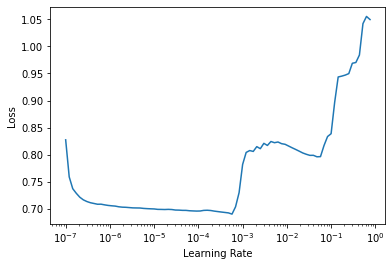

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, 5.7e-5) # We can increase depth & more to improve the result

epoch,train_loss,valid_loss,accuracy,time
0,0.652948,0.627165,0.656120,04:00
1,0.580878,0.548993,0.722400,04:08
2,0.481650,0.492818,0.760320,04:09
3,0.458933,0.472389,0.770200,04:09
4,0.432385,0.461327,0.778800,04:10
5,0.409607,0.460612,0.780320,04:08


Fast.AI approach

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.624490,0.643156,0.625000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.441161,0.550412,0.755000,00:27
1,0.380404,0.602693,0.650000,00:27
2,0.316619,0.483822,0.750000,00:27
3,0.256229,0.535840,0.750000,00:27


In [ ]:
learn.show_results()  

## Text Generation

First of we generate text based on the IMDB dataset, but then we've also got the shakespeare txt file afterwards for personal testing :)

### The Model

Code we've done, the essential model

In [ ]:
class SelfAttentionAutoRegressive(Module):
  def __init__(self, k, heads=8):
    self.k, self.heads = k, heads

    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues  = nn.Linear(k, k * heads, bias=False)

	  # This unifies the outputs of the different heads into 
    # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()

    h = self.heads

    queries = self.toqueries(x).view(b, t, h, k)
    keys    = self.tokeys(x)   .view(b, t, h, k)
    values  = self.tovalues(x) .view(b, t, h, k)

    # - fold heads into the batch dimension ... contiguous = reshapes matrix in memory
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    queries = queries / (k ** (1/4))
    keys    = keys / (k ** (1/4))

    # - get dot product of queries and keys, and scale
    dot = torch.bmm(queries, keys.transpose(1, 2))

    indices = torch.triu_indices(t, t, offset=1, device='cuda') # ---OBS--- this also changed
    dot[:, indices[0], indices[1]] = float('-inf')

    # - dot has size (b*h, t, t) containing raw weights

    dot = F.softmax(dot, dim=2) 
    # - dot now contains row-wise normalized weights

    # apply the self attention to the values
    out = torch.bmm(dot, values).view(b, h, t, k)

    # swap h, t back, unify heads
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)
    return self.unifyheads(out)

In [ ]:
class TransformerBlock(Module):
  def __init__(self, k, heads):
    super().__init__()

    self.attention = SelfAttentionAutoRegressive(k, heads=heads)

    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.ff = nn.Sequential(
      nn.Linear(k, 4 * k),
      nn.ReLU(),
      nn.Linear(4 * k, k)
    )

  def forward(self, x):
    attended = self.attention(x)
    x = self.norm1(attended + x)
    
    fedforward = self.ff(x)
    return self.norm2(fedforward + x)

In [ ]:
class Transformer(Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, device):
        super().__init__()

        self.device = device
        self.seq_length = seq_length
        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k)
        self.pos_emb = nn.Embedding(seq_length, k)

		    # The sequence of transformer blocks that does all the 
        # heavy lifting
        tblocks = [TransformerBlock(k=k, heads=heads) for x in range(depth)]
        self.tblocks = nn.Sequential(*tblocks)

		    # Maps the final output sequence to class logits
        self.toprobs = nn.Linear(k, num_tokens)

    def forward(self, x):
        """
        :param x: A (b, t) tensor of integer values representing 
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the 
                 classes (where c is the nr. of classes).
        """
		    
        # generate token embeddings
        # print(x.size())
        
        tokens = self.token_emb(x)
        b, t, k = tokens.size()
        # print(b, t, k)

        # generate position embeddings
        positions = torch.arange(t, device=self.device)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)
        
        x = tokens + positions
        x = self.tblocks(x)
        
        # Average-pool over the t dimension and project to class 
        # probabilities
        x = self.toprobs(x.view(b*t, k)).view(b, t, self.num_tokens)
        # print(x.size())
        return F.log_softmax(x, dim=2)

### The Text Generation
- Data Collection
- Training Loop
- Validation

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

(#2) [Path('/root/.fastai/data/imdb_sample/texts.csv'),Path('/root/.fastai/data/imdb_sample/models')]

In [ ]:
df = pd.read_csv(path/'texts.csv')

In [ ]:
df.head(1)

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False


In [ ]:
dls = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, valid_col='is_valid', seq_len=256)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch(max_n=1)

,text,text_
0,"xxbos i enjoyed this movie . xxmaj unlike like some of the xxunk up , xxunk trash that is passed off as action movies , xxmaj playing xxmaj god is simple and realistic , with characters that are believable , action that is not over the top and enough twists and turns to keep you interested until the end . \n\n xxmaj well directed , well acted and a good story . xxbos xxmaj for those fans of xxmaj laurel and xxmaj hardy , the 1940s and beyond were a very sad time for the team . xxmaj their xxunk with xxmaj xxunk xxmaj xxunk xxmaj studios had xxunk and now they were "" free xxunk to work for any studio who xxunk them a job . xxmaj unfortunately , xxmaj fox , xxup xxunk , xxup xxunk ( without xxmaj xxunk ) and even a xxmaj french film company","i enjoyed this movie . xxmaj unlike like some of the xxunk up , xxunk trash that is passed off as action movies , xxmaj playing xxmaj god is simple and realistic , with characters that are believable , action that is not over the top and enough twists and turns to keep you interested until the end . \n\n xxmaj well directed , well acted and a good story . xxbos xxmaj for those fans of xxmaj laurel and xxmaj hardy , the 1940s and beyond were a very sad time for the team . xxmaj their xxunk with xxmaj xxunk xxmaj xxunk xxmaj studios had xxunk and now they were "" free xxunk to work for any studio who xxunk them a job . xxmaj unfortunately , xxmaj fox , xxup xxunk , xxup xxunk ( without xxmaj xxunk ) and even a xxmaj french film company who"


In [ ]:
len(dls.vocab),dls.one_batch()[0].size()

(7080, (64, 256))

In [ ]:
learn = Learner(dls, Transformer(k=256, heads=8, depth=3, seq_length=256, num_tokens=len(dls.vocab), device=dls.device), loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0014454397605732083)

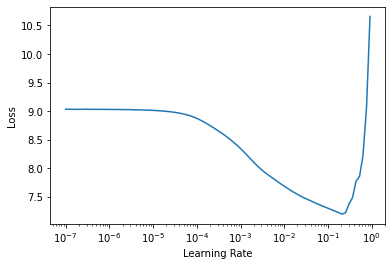

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4)  # Add suggested LR if you'd like
learn.fit_one_cycle(4)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,5.952718,6.005916,00:09
1,5.943147,5.950939,00:09
2,5.907956,5.901570,00:09
3,5.869049,5.870370,00:09


epoch,train_loss,valid_loss,time
0,5.782402,5.828668,00:09
1,5.687460,5.575956,00:09
2,5.571561,5.469945,00:09
3,5.484975,5.450408,00:09


epoch,train_loss,valid_loss,time
0,5.322245,5.439701,00:09
1,5.280037,5.311460,00:09
2,5.215474,5.259928,00:09
3,5.167902,5.247015,00:09


In [ ]:
def predict(self, text, n_words=1, no_unk=True, temperature=1., min_p=None, no_bar=False,
            decoder=decode_spec_tokens, only_last_word=False):
    "Return `text` and the `n_words` that come after"
    
    idxs = idxs_all = self.dls.test_dl([text]).items[0].to(self.dls.device)
    if no_unk: unk_idx = self.dls.vocab.index(UNK)
    for _ in (range(n_words) if no_bar else progress_bar(range(n_words), leave=False)):
        with self.no_bar(): preds,_ = self.get_preds(dl=[(idxs[None],)])
        # print(preds.size())
        res = preds[0][-1]
        if no_unk: res[unk_idx] = 0.
        if min_p is not None:
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
        idxs = idxs_all = torch.cat([idxs_all, idxs.new([idx])])
        if only_last_word: idxs = idxs[-1][None]

    num = self.dls.train_ds.numericalize
    tokens = [num.vocab[i] for i in idxs_all if num.vocab[i] not in [BOS, PAD]]
    sep = self.dls.train_ds.tokenizer.sep
    return sep.join(decoder(tokens))

@delegates(Learner.get_preds)
def get_preds(self, concat_dim=1, **kwargs):
  return super().get_preds(concat_dim=concat_dim, **kwargs)

In [ ]:
predict(learn, "I think its a very", n_words=20, temperature=1.)

'i think its a very Who spoiler to sort with a flat in clumsy and my world to sit to american to were even'

In [ ]:
learn.save('gen.pkl')

In [ ]:
# Shakespeare for those that'd want it!
!wget https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt

FastAI way

In [ ]:
predict(language_model_learner(dls, AWD_LSTM), "I think its", n_words=2, temperature=1.)